# Trading Assets with DQN

The goal of this exercise is to train an RL agent of DQN variant to trade Bitcoins on a minute level. Our objective is simply to get **the highest returns possible within any given 10-hour period**. The dataset of Bitcoin prices at 1-min intervals from select exchanges, Jan 2012 to July 2018, comes from [Kaggle's Bitcoin Historical Data](https://www.dropbox.com/s/b2wo4cc3hotcx63/bitstampUSD_1-min_data_2012-01-01_to_2018-06-27.csv).

In [0]:
# #Uncomment if you are running from Google Colaboratory
%tensorflow_version 2.x
#data
!wget https://www.dropbox.com/s/b2wo4cc3hotcx63/bitstampUSD_1-min_data_2012-01-01_to_2018-06-27.csv

TensorFlow 2.x selected.
--2019-10-17 09:58:56--  https://www.dropbox.com/s/b2wo4cc3hotcx63/bitstampUSD_1-min_data_2012-01-01_to_2018-06-27.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/b2wo4cc3hotcx63/bitstampUSD_1-min_data_2012-01-01_to_2018-06-27.csv [following]
--2019-10-17 09:58:57--  https://www.dropbox.com/s/raw/b2wo4cc3hotcx63/bitstampUSD_1-min_data_2012-01-01_to_2018-06-27.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc24be5944e1ff2d272b858a3bf0.dl.dropboxusercontent.com/cd/0/inline/AqkXnozquADVDpSC7YnZZPgbCE-VnVZewOh7rdwSxR-q4U0nuOUq6dApcLm9qToqIRt1yHIARfKNl0tAcn3vdea91qbK_LAkO-c3_hQy9If1Sg/file# [following]
--2019-10-17 09:58:57--  https://uc24be5944e1ff2d272b858a3bf0.dl.dropboxusercontent.com/cd

In [0]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
from plotnine import *
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from collections import deque

import warnings
warnings.filterwarnings('ignore')

## Explore Dataset

We use difference in price of `close` as the returns.  Go to [Kaggle](https://www.kaggle.com/mczielinski/bitcoin-historical-data/version/14), and **fill in the blank** for the following items about the dataset:

* `timestamp`:
* `open`:
* `high`:
* `low`:
* `close`: price at the end of the minute
* `volume_btc`:
* `volume_currency`:
* `weighted_close`:
* Why should we use or not use `close` to calculate our returns?

In [0]:
df = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2018-06-27.csv')
df.columns = ['timestamp','open','high','low','close','volume_btc','volume_currency','weighted_close']
df.head()

,timestamp,open,high,low,close,volume_btc,volume_currency,weighted_close
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2,1325318040,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
3,1325318100,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
4,1325318160,4.39,4.39,4.39,4.39,0.455581,2.0,4.39


As we can see, the first few years of Bitcoin is not so interesting so we will use the last 10,000 minutes as our validation set and the last 100,000 minutes (excluding validation set) as our training set.

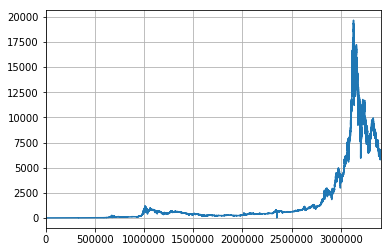

In [0]:
df.close.plot(grid=True)

In [0]:
train_df = df.iloc[-100000:-10000,:].copy()
valid_df = df.iloc[-10000:,:].copy()

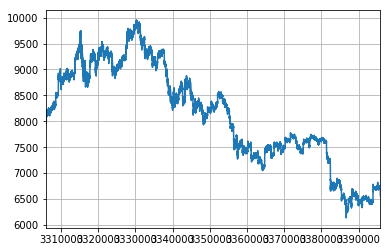

In [0]:
train_df.close.plot(grid=True)

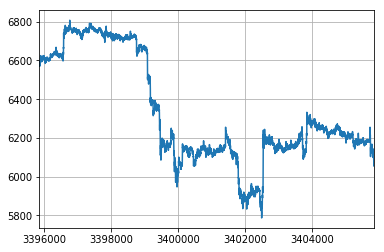

In [0]:
valid_df.close.plot(grid=True)

## Build Environment

Half (or more) of the work to do reinforcement learning in real life is to formulate the environment to fit the objective. Here our somewhat unrealistic yet suitable-for-educational-setting objective is to get an agent that achieves the highest returns in any given 10-hour window. We assume 0.5% commission (you need to pay a small fee to change your position) and 0% risk-free rate (the safest alternative asset you can invest other than Bitcoin has 0% returns).

The class `SingleStockEnvironment` below is given as a guideline for an environment that comply with our objective. Some tips for implementation:
* Think about what the agent should know to make a decision and include all of those as a state such as technical indicators, previous actions, and so on.
* Reward should be aligned with the objective. 
* **Bonus** Obviously this environment is unrealistic with risk-free rate and only one asset. What can you do to make it more realistic?

In [0]:
import numpy as np
import pandas as pd
import random

class SingleStockEnvironment:
    def __init__(self, df, episode_len = 600, short_window = 15, long_window = 60,
                state_cols = ['hodl','close_change','short','long','reward','timestamp','signal','mom_signal']):
        '''
        Default:
        * take input `df` which has at least `timestamp` and `close`
        * no commission; risk free rate of 0%
        * benchmark with buy and HODL and momentum strategies only
        '''
        
        self.current_index = 0
        self.length_data = -1
        self.df = []
        
        self.episode_len = 600
        self.short_window = short_window
        self.long_window = long_window
        self.master_df = self.process_df(df.copy())
        self.state_cols = state_cols
        self.reset()
        
    def reset(self):
        '''
        Fill in the blank
        * set current index as 0
        * sample a data frame with episode length `self.episode_len` from `self.master_df`
        * return current state as a numpy array
        ''' 
        
        self.df = []
        self.current_index = 0
        start = random.randint(0,self.length_data-self.episode_len)
        for i in range(start,start+self.episode_len):
          #print("i=",i)
          data = dict()
          for c in self.state_cols:
            data[c] = self.master_df[c][i]
          self.df.append(data)
        #print(len(self.df))
        return self.get_state()
    
    def step(self, action):
        #action 0 = down
        #action 1 = do nothing
        #action 2 = up
        
        '''
        Fill in the black
        Default: take either `long` (1) or `short` (-1) as action
        Possible improvements: include `do nothing` (0) as liquidating all existing positions, 
        especially interesting when taking into account commmissions
        Input: action (don't forget to record it to `self.df`)
        Output: next state, reward, done, info (can be any useful information)
        '''
        #record action
        #self.df['action'][self.current_index] = action
        
        
        # 0 -> -1 = down
        # 1 -> 0 = do nothing
        # 2 -> 1 = up
        action -= 1
        
        
        current_state = self.get_state()
        
        #reward
        reward = action * self.get_reward()
        discount = reward*0.005
        reward = action * reward
        reward -= discount
        
        if(action == 0): reward-=1
        
        
        #print("reward = ",reward)
        
        #increment idx
        self.current_index += 1
        #done
        if(self.current_index >= self.episode_len):
            #print('Done!!!')
            done=True
        else: 
           done=False
        
        #info
        info = {'state':current_state,
                'action':action,
                'reward':reward,
                'done':done}
        if(done): self.current_index=0
        next_state = self.get_state()
        info['next_state'] = next_state
        if(done):
          self.current_index=self.episode_len-1
        return next_state,reward,done, info
        
    def get_state(self):
        '''
        Fill in the blank
        Default: [HODL portfolio (from first period), close price change from last period, 
        short indicator, long indicator]
        Possible: indicators, previous timesteps
        '''
        
        temp_cols = ['hodl','close_change','reward','signal','mom_signal']
        
        state = []
        for c in temp_cols:
          #print('current_index = ',self.current_index)
          state.append(self.df[self.current_index][c])
        state = np.array(state)
        return state
    
    def get_reward(self):
        '''
        Fill in the blank
        Default: use change in portfolio as rewards
        Possible: sharpe ratio, sortino ratio, etc.
        '''
        if(self.current_index<len(self.df)-1): 
          reward = self.df[self.current_index+1]['hodl'] - self.df[self.current_index]['hodl']
        else:
          reward = self.df[0]['hodl'] - self.df[self.current_index]['hodl']
        #reward = self.df[self.current_index]['reward']
        return reward
        
    def process_df(self,df):
        '''
        Fill in the blank
        Since asset prices can swing in wide ranges, it is safer to use their changes,
        or better the change in portfolio ASSUMING we just buy the asset and hold for the
        entire period (known by the Bitcoin community as HODL).
        
        Calculate 
        * the percentage of change in `close` compared to last 1 period as `close_change`
        * HODL portfolio as `hodl`
        '''
        copy_df = df.copy()
        copy_df = copy_df.shift(periods=1)
        df['close_change'] = (df['close'] - copy_df['close'])
        df['close_change'][0] = 0.0
        
        df['hodl'] = df['close']
        
        #momentum features
        # df['short'] = df.hodl.rolling(window=self.short_window, min_periods=1, center=False).mean()
        df['short'] = df.hodl.ewm(span=self.short_window, min_periods=1).mean()
        # df['long'] = df.hodl.rolling(window=self.long_window, min_periods=1, center=False).mean()
        df['long'] = df.hodl.ewm(span=self.long_window, min_periods=1).mean()
        df['mom_signal'] = 0
        df.iloc[self.short_window:,df.columns.get_loc('mom_signal')] = np.where(df['short'][self.short_window:] > df['long'][self.short_window:], 1, -1)
        
        '''
        Fill in the blank
        Calculate
        * the returns we will get IN THE NEXT PERIOD given that we buy at the current price
        '''
        copy_df = df.copy()
        copy_df = copy_df.shift(periods=1)
        df['reward'] = df['hodl'] - copy_df['hodl']
        df['reward'][0] = 0        
        
        #set length data 
        #print('shape = ',df.shape)
        self.length_data = df.shape[0]
        #initialize signal
        df['signal'] = 0
        
        df['signal'] = np.where(df['close_change']>0 , 1 ,-1)
        
#         for i in range(self.length_data):
#           if(df['close_change'][i]>0): df['signal'][i]=1
#           elif(df['close_change'][i]<0): df['signal'][i]=-1
        
        return df

## Build Memory

Create a memory to store transitions and feed to the agent.

In [0]:
class VanillaMemory:
    def __init__(self, memory_size):
        self.memory_size = memory_size
        self.memory = deque(maxlen=memory_size) 
    def add(self, *args):
        self.memory.append({'state':args[0],
                            'action':args[1],
                            'reward':args[2],
                            'next_state':args[3],
                            'done':args[4]})
    def sample(self, batch_size):
        ts = random.sample(self.memory,batch_size)
        states = tf.cast(np.vstack([t['state'] for t in ts]),dtype=tf.float32)
        actions = tf.cast(np.vstack([t['action'] for t in ts]),dtype=tf.int32)
        rewards = tf.cast(np.vstack([t['reward'] for t in ts]),dtype=tf.float32)
        next_states = tf.cast(np.vstack([t['next_state'] for t in ts]),dtype=tf.float32)
        dones = tf.cast(np.vstack([t['done'] for t in ts]),dtype=tf.float32)
        return (states,actions,rewards,next_states,dones)
    def __len__(self):
        return len(self.memory)

In [0]:
#this is the entirety of prioritized memory class
class PrioritizedMemory:
    def __init__(self, memory_size, alpha = 0.6):
        self.memory_size = memory_size
        self.memory = deque(maxlen=memory_size)
        self.alpha = alpha
        self.priority = deque(maxlen=memory_size)
        self.probs = np.zeros(memory_size)
        
    def add(self, *args):
        max_prior = max(self.priority) if self.memory else 1.
        t = {'state':args[0],'action':args[1],'reward':args[2],'next_state':args[3],'done':args[4]}
        self.memory.append(t)
        #give latest transition max priority for optimistic start
        self.priority.append(max_prior)
        
    def prior_to_prob(self):
        #uniform sampling when alpha is 0
        probs = np.array([i**self.alpha for i in self.priority]) 
        self.probs[range(len(self.priority))] = probs
        self.probs /= np.sum(self.probs)
        
    def sample(self, batch_size, beta = 0.4):
        #calculate prob every time we will sample
        self.prior_to_prob()
        idx = np.random.choice(range(self.memory_size), batch_size, replace=False, p=self.probs)
        ts = [self.memory[i] for i in idx]
        
        #stitch tuple
        states = tf.cast(np.vstack([t['state'] for t in ts]),dtype=tf.float32)
        actions = tf.cast(np.vstack([t['action'] for t in ts]),dtype=tf.int32)
        rewards = tf.cast(np.vstack([t['reward'] for t in ts]),dtype=tf.float32)
        next_states = tf.cast(np.vstack([t['next_state'] for t in ts]),dtype=tf.float32)
        dones = tf.cast(np.vstack([t['done'] for t in ts]),dtype=tf.float32)
        
        #importance sampling weights
        #higher beta, higher compensation for prioritized sampling
        sampling_weights = (len(self.memory)*self.probs[idx])**(-beta)
        #normalize by max weight to always scale down
        sampling_weights = sampling_weights / np.max(sampling_weights) 
        sampling_weights = tf.cast(sampling_weights, dtype=tf.float32)
        return(states,actions,rewards,next_states,dones)
    
    def update_priority(self, idx, losses):
        for i, l in zip(idx, losses): 
            self.priority[i] = l.numpy().squeeze()
        
    def __len__(self):
        return len(self.memory)

## Build Nework

Create an architecture tempalte for the networks to use to estimate action and/or state values. You can go crazy with convolutions, recurrent networks or transformers.

In [0]:
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
import random
class DenseNetwork(models.Model):
    def __init__(self, output_size, hidden_sizes, **args):
        super(DenseNetwork, self).__init__()
        self.body = [layers.Dense(i,activation = 'relu') for i in hidden_sizes]
        self.head = layers.Dense(output_size)
    def call(self, x, training=True):
        for l in self.body: x = l(x)
        return self.head(x)

In [0]:
class DuelingNetwork(models.Model):
    def __init__(self, output_size, hidden_sizes, **args):
        super(DuelingNetwork, self).__init__()
        self.feature = [layers.Dense(i,activation='relu') for i in hidden_sizes[:-1] ]
        self.value = [layers.Dense(hidden_sizes[-1],activation='relu') , layers.Dense(1)]
        self.advantage = [layers.Dense(hidden_sizes[-1],activation='relu') , layers.Dense(output_size)]
    def call(self, x, training=True):
        for l in self.feature: x=l(x)
        adv = x
        for a in self.advantage: adv = a(adv)
        val = x
        for v in self.value: val = v(val)
        return adv+val-tf.reduce_mean(adv)

## Build Agent

Create a DQN agent. Here's a template of vanilla DQN we covered in class you will use as base. You **MUST** use at least 3 of the improvements from the [Rainbow paper](https://arxiv.org/pdf/1710.02298.pdf). In case that the improvements really hurt your performance or you have a customized way of improving the model, you **MUST** show the results to justify.

In [0]:
class DQNAgent:
    def __init__(self, state_size, action_size, replay_memory,
        lr=1e-3, bs = 64, clip=1., hidden_sizes = [256,256],
        gamma=0.99, tau= 1e-3, update_interval = 5, update_times = 1,
        double = True, Architecture=DuelingNetwork):
        
        self.state_size = state_size
        self.action_size = action_size
        self.hidden_sizes = hidden_sizes
        self.lr = lr
        self.bs = bs
        self.gamma = gamma
        self.update_interval = update_interval
        self.update_times = update_times
        self.tau = tau
        self.losses = []
        self.clip = clip
        self.double = double
        self.Architecture = Architecture

        #networks
        self.network_local = Architecture(output_size=self.action_size, 
                                          hidden_sizes = self.hidden_sizes, 
                                          input_size=state_size)
        self.network_local.build(input_shape=(None,self.state_size))
        self.network_target = Architecture(output_size=self.action_size,
                                           hidden_sizes=self.hidden_sizes,
                                           input_size=state_size)
        self.network_target.build(input_shape=(None,self.state_size))
        self.network_target.set_weights(self.network_local.get_weights())
        
        #optimizer
        self.optimizer = tf.keras.optimizers.Adam(learning_rate = self.lr, clipvalue=self.clip)
        
        # replay memory
        self.memory = replay_memory
        # count time steps and episodes
        self.t_step = 0
        self.episodes = 0
    def get_episodes(self):
        #print("episodes = ",self.episodes)
        return self.episodes
    
    def step(self, state, action, reward, next_state, done):
        #add transition to replay memory
        self.memory.add(state, action, reward, next_state, done, #for all others 
                        self.episodes, self.t_step) #for nstep memory

        #increment episodes if done
        if done: 
            self.t_step = 0
            self.episodes+=1
        
        #update target network
        self.soft_update()
        #self.hard_update()
        
        
        # learn every self.t_step
        self.t_step += 1
        if self.t_step % self.update_interval == 0:
            if len(self.memory) > self.bs:
                for _ in range(self.update_times):
                    if isinstance(self.memory,PrioritizedMemory):
                        transitions = self.memory.sample(self.bs, self.get_beta(self.get_episodes()))
                    else:
                        transitions = self.memory.sample(self.bs)
                    loss = self.learn(transitions)
                    self.losses.append(loss)
                   

    def act(self, state):
        eps = self.get_eps(self.episodes)
        action_values = self.network_local(tf.cast(state[None,:],dtype=tf.float32))
        #epsilon greedy exploration
        if random.random() > eps:
            return np.argmax(action_values.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    #we use tf.function decorator for training process to switch from eager to static graph
    #NOT compatible with PrioritizedMemory yet
    #with decorator
    #1.64 ms ± 45.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
    #without decorator
    #2.93 ms ± 442 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
#     @tf.function
    def learn(self, transitions):
        states, actions, rewards, next_states, dones = transitions

        if self.double:
            max_actions_next = tf.cast(tf.argmax(self.network_local(next_states),1), dtype=tf.int32)
            seq = tf.range(0, actions.shape[0])
            max_action_idxs = tf.transpose(tf.stack([seq, max_actions_next]))
            q_targets_next = tf.gather_nd(self.network_target(next_states), max_action_idxs)[:,tf.newaxis]
        else:
            q_targets_next = tf.reduce_max(self.network_target(next_states),1)[:,tf.newaxis]

        q_targets = rewards + (self.gamma * q_targets_next) * (1 - dones)
        q_targets = q_targets[:,0] #flatten q_targets

        with tf.GradientTape() as tape:
            #get predictions of all actions
            preds = self.network_local(states)
            
            #get index of actions used to calculate q_expected
            actions = actions[:,0] #flatten actions
            seq = tf.range(0, actions.shape[0])
            action_idxs = tf.transpose(tf.stack([seq, actions]))

            #get q values only at specific action indice
            #tensorflow has this weird way to gather where you need to put index as
            #[[0, action_idx1],[1, action_idx2],...,[n, action_idxn]]
            q_expected = tf.gather_nd(preds, action_idxs)
            
            #calculate loss
            loss = self.vanilla_loss(q_targets, q_expected)
            
            #get gradients
            gradients = tape.gradient(loss, self.network_local.trainable_weights)
        
        #apply gradients
        self.optimizer.apply_gradients(zip(gradients,self.network_local.trainable_weights))

        return loss
    def get_beta(self,i, beta_start = 0.4, beta_end = 1, beta_growth = 1.05):
        #print("i=",i)
        beta = min(beta_start * (beta_growth ** i), beta_end)
        return(beta)

    def vanilla_loss(self, q_targets, q_expected):
        return tf.keras.losses.mse(q_targets, q_expected)
    
    def hard_update(self):
        if self.t_step % 1/self.tau==0:
            self.network_target.set_weights(self.network_local.get_weights())

    def soft_update(self):
        weights_local = np.array(self.network_local.get_weights())
        weights_target = np.array(self.network_target.get_weights())
        self.network_target.set_weights(self.tau * weights_local + (1 - self.tau) * weights_target)
        
    def get_eps(self, i, eps_start = 1., eps_end = 0.001, eps_decay = 0.9):
        eps = max(eps_start * (eps_decay ** i), eps_end)
        return(eps)

## Win The Junior League

Before spending time to train your agent on actual data, which usually takes a long time, make sure your agent is properly coded by training it on the "junior" version of things you want to do. Here let us train it on `CartPole-v1`(also try `MountainCar-v0` and other gym environments if you have time), always increasing or decreasing, and sine-wave pattern of price.

### `CartPole-v1`

Your model might not converge as fast as simpler models on `CartPole-v1` especially if you are trying to incorporate more complex features, but still if your model does not converge at all, that is a sign of a problem. More importantlym, getting your model to approach the solve score in a stable manner is also a sign of a robust agent. For this reason, we will use an easier solve score of 100.

**To-do**: Use your own agent to (soft) solve `CartPole-v1` and make sure everything ~~might be~~ is alright.

In [0]:
import gym
env = gym.make('CartPole-v1')

In [0]:
# from solutions.memories import VanillaMemory
# from solutions.agents import DQNAgent

mem = PrioritizedMemory(int(1e5)) 
a = DQNAgent(state_size = env.reset().shape[0], 
             action_size = env.action_space.n, replay_memory = mem,
             hidden_sizes=[64,64], double=True)

In [0]:
scores = []
scores_deque = deque(maxlen=100) 
moving_scores = []
solved_score=100

for i in tqdm_notebook(range(10000)):
    if (i+1) % 100==0: print(f'Episdoe {i} Moving Average: {np.mean(scores_deque)}')
    state = env.reset()
    score = 0
    actions = []
    while True:
        #select action
        action = a.act(state)  
        actions.append(action)

        #env step
        next_state, reward, done, info = env.step(action)   
        
        #agent step
        a.step(state,action,reward,next_state,done)
        
        #collect score
        score += reward
        
        #go to next state
        state = next_state   
        
        #break if done
        if done: break
            
    #book keeping
    scores.append(score)
    scores_deque.append(score)
    moving_scores.append(np.mean(scores_deque))

    if moving_scores[-1] > solved_score: 
        print(f'Solved at Play {i} with moving average of {moving_scores[-1]}')
        break

Episdoe 99 Moving Average: 9.909090909090908
Episdoe 199 Moving Average: 9.59
Episdoe 299 Moving Average: 9.46
Episdoe 399 Moving Average: 9.41
Episdoe 499 Moving Average: 9.55
Episdoe 599 Moving Average: 9.97
Episdoe 699 Moving Average: 42.94
Solved at Play 723 with moving average of 101.1


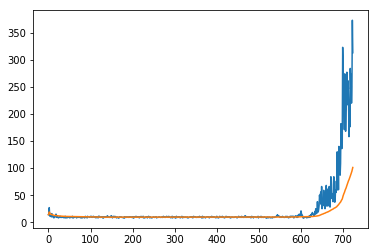

In [0]:
plt.plot(scores)
plt.plot(moving_scores)

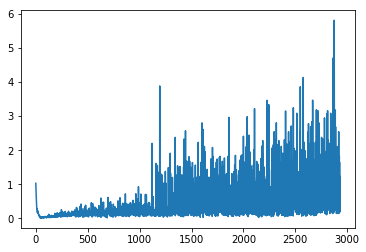

In [0]:
plt.plot(a.losses)

### Always Increasing

Another step from gym environments is to have the agent solve a stupidly simple version of our environment. Here we have it trade a hypothetical asset where the price always goes up.

**To-do**: Make sure your agent always go long when trading this always increasing asset.

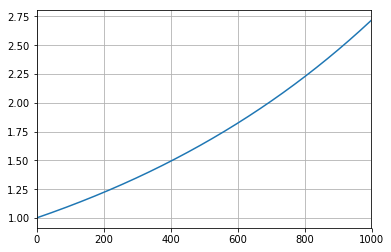

In [0]:
df = pd.DataFrame({'timestamp':range(1,1001), 'close': [1.001**i for i in range(1,1001)]})
df.close.plot(grid=True)

In [0]:
# from solutions.environments import SingleStockEnvironment
# from solutions.memories import VanillaMemory
# from solutions.agents import DQNAgent


env = SingleStockEnvironment(df)
mem = VanillaMemory(int(1e5)) 
a = DQNAgent(state_size = env.reset().shape[0], 
             action_size = 3, replay_memory = mem,
             hidden_sizes=[64,64], double=True)

In [0]:
#train agent
infos = []
for i in tqdm_notebook(range(5)):
    state = env.reset()
    while True:
        action_idx = a.act(state)
        next_state, reward, done, info = env.step(action_idx)
        #print(type(state),type(action_idx),type(reward),type(next_state),type(done))
        a.step(state,action_idx,reward,next_state,done)
        state = next_state
        if done: 
            infos.append(info)
            break

In [0]:
#test agent
a.episodes=100 #switch from epsilon greedy to just greedy
state = env.reset()
while True:
    action_idx = a.act(state)
    next_state, reward, done, info = env.step(action_idx)
    a.step(state,action_idx,reward,next_state,done)
    state = next_state
    if done: 
        infos.append(info)
        break

In [0]:
info

{'action': -1,
 'done': True,
 'next_state': array([1.44602097e+00, 1.44457639e-03, 1.44457639e-03, 1.00000000e+00,
        1.00000000e+00]),
 'reward': -1.1913067185513404,
 'state': array([2.63140079e+00, 2.62877201e-03, 2.62877201e-03, 1.00000000e+00,
        1.00000000e+00])}

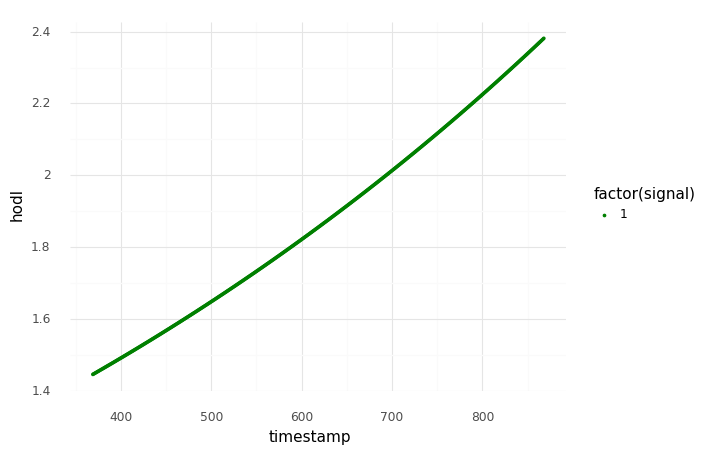

<ggplot: (8781308526165)>

In [0]:
temp = pd.DataFrame(env.df)
df_m = temp[['timestamp','hodl','short','long','signal','mom_signal']]\
    .reset_index(drop=True).head(500)
g = (ggplot(df_m,aes(x='timestamp',y='hodl'))+
     geom_line()+ theme_minimal() +
#      geom_line(df_m, aes(x='timestamp',y='short'),color='orange') +
#      geom_line(df_m, aes(x='timestamp',y='long'),color='purple') +
     geom_point(df_m,aes(x='timestamp',y='hodl',color='factor(signal)'),size=0.5) +
     scale_color_manual(['green'])
    )
g

In [0]:
state = env.get_state()

In [0]:
#see if action values are stable
import tensorflow as tf
state = env.get_state()
a.network_local(tf.cast(state[None,:],dtype=tf.float32)), a.act(state)

(<tf.Tensor: id=1944541, shape=(1, 3), dtype=float32, numpy=array([[-0.07413962, -1.0821983 , -0.10968289]], dtype=float32)>,
 0)

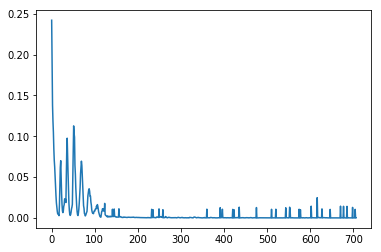

In [0]:
plt.plot(a.losses)

### Always Decreasing

**To-do**: Make sure your agent always go short when trading an always decreasing asset.

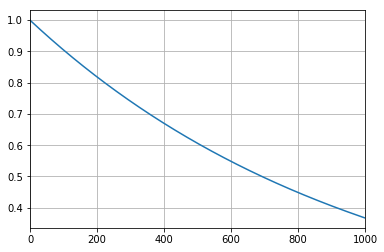

In [0]:
df = pd.DataFrame({'timestamp':range(1,1001), 'close': [0.999**i for i in range(1,1001)]})
df.close.plot(grid=True)

In [0]:
# from solutions.memories import VanillaMemory
# from solutions.agents import DQNAgent


env = SingleStockEnvironment(df)
mem = VanillaMemory(int(1e5)) 
a = DQNAgent(state_size = env.reset().shape[0], 
             action_size = 3, replay_memory = mem,
             hidden_sizes=[64,64], double=True)

In [0]:
#train agent
infos = []
for i in tqdm_notebook(range(5)):
    state = env.reset()
    while True:
        action_idx = a.act(state)
        next_state, reward, done, info = env.step(action_idx)
        a.step(state,action_idx,reward,next_state,done)
        state = next_state
        if done: 
            infos.append(info)
            break

In [0]:
#test agent
a.episodes=100 #switch from epsilon greedy to just greedy
state = env.reset()
while True:
    action_idx = a.act(state)
    next_state, reward, done, info = env.step(action_idx)
    a.step(state,action_idx,reward,next_state,done)
    state = next_state
    if done: 
        infos.append(info)
        break

In [0]:
info

{'action': 1,
 'done': True,
 'next_state': array([ 9.38913878e-01, -9.39853731e-04, -9.39853731e-04, -1.00000000e+00,
        -1.00000000e+00]),
 'reward': 0.42114970429072535,
 'state': array([ 5.15647843e-01, -5.16164007e-04, -5.16164007e-04, -1.00000000e+00,
        -1.00000000e+00])}

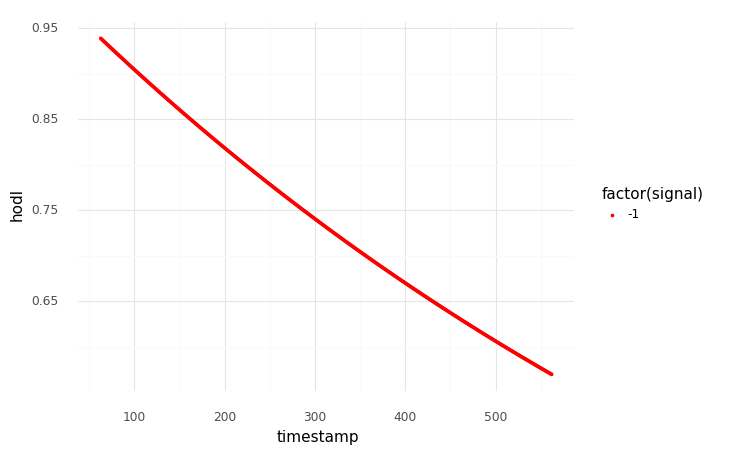

<ggplot: (-9223363255546252849)>

In [0]:
temp = pd.DataFrame(env.df)
df_m = temp[['timestamp','hodl','short','long','signal','mom_signal']]\
    .reset_index(drop=True).head(500)
g = (ggplot(df_m,aes(x='timestamp',y='hodl'))+
     geom_line()+ theme_minimal() +
#      geom_line(df_m, aes(x='timestamp',y='short'),color='orange') +
#      geom_line(df_m, aes(x='timestamp',y='long'),color='purple') +
     geom_point(df_m,aes(x='timestamp',y='hodl',color='factor(signal)'),size=0.5) +
     scale_color_manual(['red'])
    )
g

In [0]:
#see if action values are stable
import tensorflow as tf
state = env.get_state()
a.network_local(tf.cast(state[None,:],dtype=tf.float32)), a.act(state)

(<tf.Tensor: id=2307416, shape=(1, 3), dtype=float32, numpy=array([[-0.15124878, -1.1515791 , -0.14598897]], dtype=float32)>,
 2)

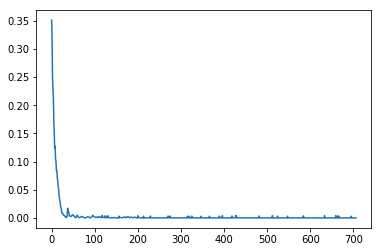

In [0]:
plt.plot(a.losses)

### Sine Wave

In a real trading setup, the model also needs to learn to distinguish between a peak and a trough, aka buy low and sell high. 

**To-do**: Make sure your model buys low and sells high.

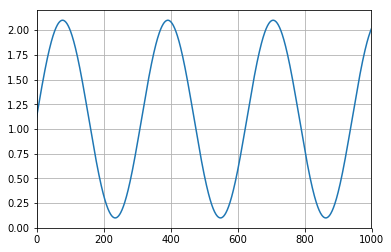

In [0]:
df = pd.DataFrame({'timestamp':range(1,1001), 'close': 1.1+np.sin(np.arange(1,1001)/50)})
df.close.plot(grid=True)

In [0]:
# from solutions.memories import VanillaMemory
# from solutions.agents import DQNAgent


env = SingleStockEnvironment(df)
mem = VanillaMemory(int(1e5)) 
a = DQNAgent(state_size = env.reset().shape[0], 
             action_size = 3, replay_memory = mem,
             hidden_sizes=[64,64], double=True)

In [0]:
#train agent
infos = []
for i in tqdm_notebook(range(20)):
    state = env.reset()
    while True:
        action_idx = a.act(state)
        next_state, reward, done, info = env.step(action_idx)
        a.step(state,action_idx,reward,next_state,done)
        state = next_state
        if done: 
            infos.append(info)
            break

In [0]:
#test agent
a.episodes=100 #switch from epsilon greedy to just greedy
state = env.reset()
rewards = []
while True:
    action_idx = a.act(state)
    next_state, reward, done, info = env.step(action_idx)
    rewards.append(reward)
    state = next_state
    if done: 
        infos.append(info)
        break

In [0]:
info

{'action': 1,
 'done': True,
 'next_state': array([ 0.10261894, -0.00164589, -0.00164589, -1.        , -1.        ]),
 'reward': -0.20559578014906993,
 'state': array([ 0.30924786, -0.01240006, -0.01240006, -1.        , -1.        ])}

If things are done right, your model will be able to buy low and sell high.

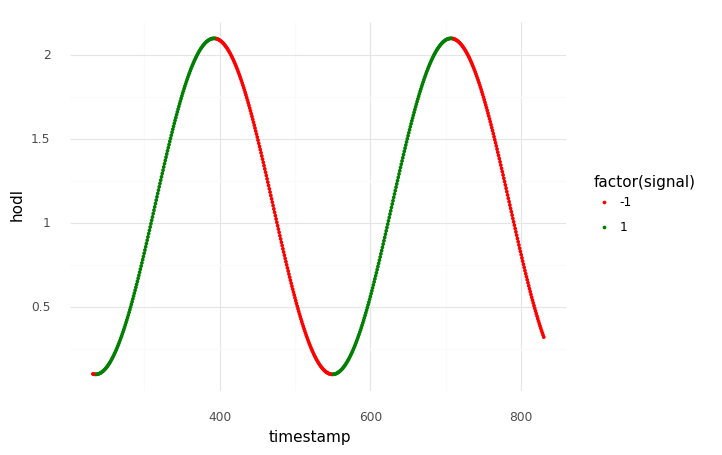

<ggplot: (8781310226878)>

In [0]:
temp = pd.DataFrame(env.df)
df_m = temp[['timestamp','hodl','short','long','signal','mom_signal','reward']].head(599)\
    .reset_index(drop=True)
#df_m['rewards'] = rewards
g = (ggplot(df_m,aes(x='timestamp',y='hodl'))+
     geom_line()+ theme_minimal() +
#      geom_line(df_m, aes(x='timestamp',y='short'),color='orange') +
#      geom_line(df_m, aes(x='timestamp',y='long'),color='purple') +
     geom_point(df_m,aes(x='timestamp',y='hodl',color='factor(signal)'),size=0.5) +
     scale_color_manual(['red','green'])
    )
g

Notice that a properly trained agent performs better than a momentum strategy, which is one of the best strategies for a sine-wave pattern.

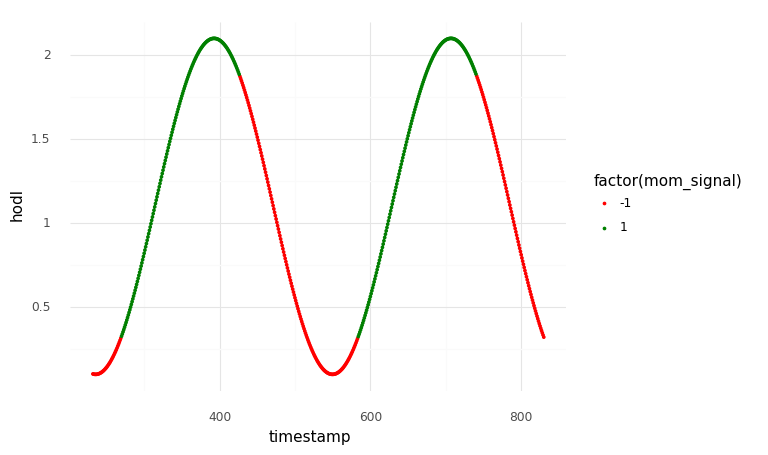

<ggplot: (-9223363255546255251)>

In [0]:
temp = pd.DataFrame(env.df)
df_m = temp[['timestamp','hodl','short','long','signal','mom_signal','reward']].head(599)\
    .reset_index(drop=True)
#df_m['rewards'] = rewards
g = (ggplot(df_m,aes(x='timestamp',y='hodl'))+
     geom_line()+ theme_minimal() +
#      geom_line(df_m, aes(x='timestamp',y='short'),color='orange') +
#      geom_line(df_m, aes(x='timestamp',y='long'),color='purple') +
     geom_point(df_m,aes(x='timestamp',y='hodl',color='factor(mom_signal)'),size=0.5) +
     scale_color_manual(['red','green'])
    )
g

In [0]:
#see if action values are stable
import tensorflow as tf
state = env.get_state()
a.network_local(tf.cast(state[None,:],dtype=tf.float32)), a.act(state)

(<tf.Tensor: id=3539451, shape=(1, 3), dtype=float32, numpy=array([[ 0.09456488, -0.888572  ,  0.09987679]], dtype=float32)>,
 2)

## The Real Deal $$$

The final boss of this exercise is to make an agent that can trade reasonably well, **at least beating all-buy and all-sell**, when averaged across 100 episodes of the validation set. You can use whatever you want as long as it is a DQN variant and you coded them up from scratch using Tensorflow 2.

**To-do**: List the improvements you used and the reasons you chose them. If you decide to NOT use at least 3 improvements, demonstrate why; for instance, if it led to worse performance, plot those performances.

1. Improvement 1 PrioritizedMemory เป็นข้อมูลของ stock ดังนั้นข้อมูลที่นำมา train ควรเป็นค่าที่ใกล้เคียงกันไม่ควรสุ่ม
2. Improvement 2 Double Deep Q-learning เพื่อเฉลี่ยค่า Q ที่ได้ให้ใกล้ความเป็นจริงมากขึ้น
3. Improvement 3 DuelingNetwork ค่า value ของ state ที่อยู่มีความสำคัญต่อการตัดสินใจมากกว่าการใช้แค่ค่า Q ที่อยู่

In [0]:
train_df.head().reset_index(drop=True)

,timestamp,open,high,low,close,volume_btc,volume_currency,weighted_close
0,1524057660,8099.63,8100.69,8093.29,8100.69,0.018115,146.735204,8100.074791
1,1524057720,8095.97,8104.60,8095.97,8100.40,1.186197,9607.355091,8099.291955
2,1524057780,8100.47,8100.47,8090.00,8090.00,4.622190,37403.471958,8092.153815
3,1524057840,8091.02,8092.08,8080.01,8083.53,7.214283,58350.249106,8088.156239
4,1524057900,8083.53,8095.40,8083.53,8095.40,1.733634,14026.366835,8090.729462


In [0]:
# from solutions.memories import VanillaMemory
# from solutions.agents import DQNAgent
# from solutions.environments import SingleStockEnvironment


env = SingleStockEnvironment(train_df.reset_index(drop=True))
mem = PrioritizedMemory(int(1e5)) 
a = DQNAgent(state_size = env.reset().shape[0], 
             action_size = 3, replay_memory = mem,
             hidden_sizes=[64,64], double=True)

In [0]:
#train agent
infos = []
for i in tqdm_notebook(range(100)):
    state = env.reset()
    while True:
        action_idx = a.act(state)
        next_state, reward, done, info = env.step(action_idx)
        a.step(state,action_idx,reward,next_state,done)
        state = next_state
        if done: 
            infos.append(info)
            break

Make sure to test on the validation dataset. We determine the results by the average over 100 episodes.

In [0]:
valid_df.head()

,timestamp,open,high,low,close,volume_btc,volume_currency,weighted_close
3395857,1529457660,6569.60,6581.12,6564.37,6575.92,9.111169,59897.888688,6574.116413
3395858,1529457720,6580.87,6600.01,6580.87,6590.52,12.468805,82243.689980,6595.955802
3395859,1529457780,6588.03,6588.36,6586.00,6586.14,2.234153,14716.059052,6586.862135
3395860,1529457840,6588.36,6597.19,6588.36,6592.50,0.358099,2361.038285,6593.255734
3395861,1529457900,6594.50,6594.50,6590.30,6590.30,1.018478,6714.895155,6593.070961


In [0]:
#test agent
env = SingleStockEnvironment(valid_df.reset_index(drop=True))
state = env.reset()
infos = []
for i in range(100):
    while True:
        action_idx = a.act(state)
        next_state, reward, done, info = env.step(action_idx)
        state = next_state
        if done: 
            infos.append(info)
            break

In [0]:
pd.DataFrame(infos).mean()

action                                                       -1
done                                                          1
next_state    [6724.569999999993, -2.5399999999999636, -2.53...
reward                                                  343.177
state         [6383.0999999999885, -9.889999999999418, -9.88...
dtype: object

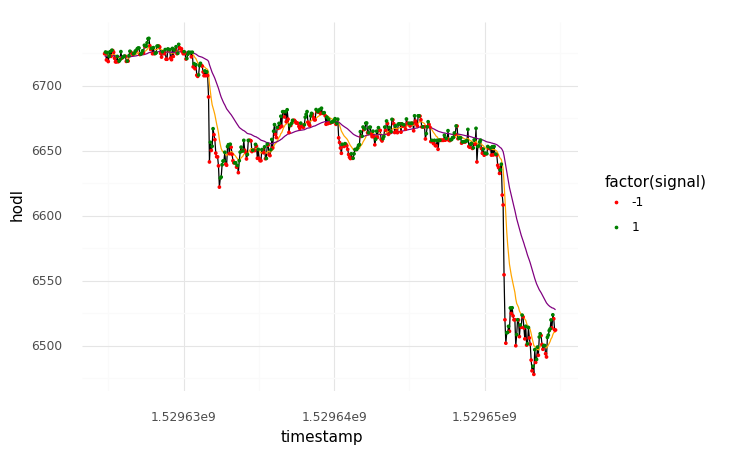

<ggplot: (-9223363255546228052)>

In [0]:
temp = pd.DataFrame(env.df)
df_m = temp[['timestamp','hodl','short','long','signal','mom_signal']]\
    .reset_index(drop=True).head(500)
g = (ggplot(df_m,aes(x='timestamp',y='hodl'))+
     geom_line()+ theme_minimal() +
     geom_line(df_m, aes(x='timestamp',y='short'),color='orange') +
     geom_line(df_m, aes(x='timestamp',y='long'),color='purple') +
     geom_point(df_m,aes(x='timestamp',y='hodl',color='factor(signal)'),size=0.5) +
     scale_color_manual(['red','green'])
    )
g

In [0]:
temp = pd.DataFrame(env.df)
temp.signal.value_counts()

-1    317
 1    283
Name: signal, dtype: int64

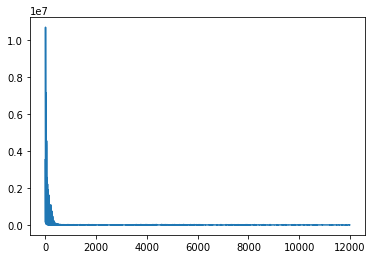

In [0]:
plt.plot(a.losses)

## Closing Remarks

Now that you have completed the exercises the hard way, here are some resources you can use for a quick-and-dirty start when working on a reinforcement learning problem, especially in trading:

* [stable-baselines](https://github.com/hill-a/stable-baselines): a set of improved implementations of reinforcement learning algorithms based on OpenAI Baselines; implemented with Tensorflow 1 with a good documentation
* [Spinning Up](https://spinningup.openai.com/en/latest/user/introduction.html): a tutorial by OpenAI; implemented with Tensorflow 1
* [TensorTrade](https://github.com/notadamking/tensortrade): a full-option reinforcement learning for trading in real life
* [Trading-Gym](https://github.com/mymusise/Trading-Gym): a simple implementation of single-asset trading